In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import os

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
from sklearn.metrics import make_scorer

def profit_scoring(y_true, y_pred):
    profit = rsm.profit(pd.Series(y_true), pd.Series(y_pred), 1, 1.41, 30)
    return profit

profit_score = make_scorer(profit_scoring, greater_is_better = True, needs_proba=True)

In [3]:
from sklearn.metrics import roc_auc_score

def performance_profit(X_test, y_test, model,model_name, breakeven):
    df_test = pd.DataFrame(X_test, columns=intuit75k_cols)
    df_test['res_y'] = y_test
    df_test['predict_res_proba_'+model_name] = model.predict_proba(X_test)[:,1]
    df_test['predicted_res_'+model_name] = np.where(df_test['predict_res_proba_'+model_name] > breakeven,1,0)
    
    confusion_matrix = pd.crosstab(df_test['res_y'], df_test['predicted_res_'+model_name], margins = True, margins_name = 'Total')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1]/2)
    
    profit = rsm.profit_max(df_test, 'res_y',1 ,'predict_res_proba_'+model_name,1.41,30)
    
    print("ROC AUC is {}".format(roc_auc))
    print("Profit is {}".format(profit))
    return roc_auc,profit,confusion_matrix

In [4]:
os.getcwd()

'/home/jovyan/git/rsm-mgta455-intuit-redux/sub-notebooks'

In [5]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


### EDA, Features

In [6]:
# rsm.distr_plot(intuit75k.loc[:,'zip_bins':])

In [7]:
intuit75k['zip801'] = np.where(intuit75k['zip'] == "00801",1,0)
intuit75k['zip804'] = np.where(intuit75k['zip'] == "00804",1,0)
intuit75k['Res_zip_bin'] = np.where(intuit75k['zip_bins'] == 1,1,0)

In [8]:
def make_version_status(x, y):
    if x == 1 and y == 0:
        return "BoughtV1_CurrentV1"
    if x == 0 and y == 1:
        return "BoughtV1_CurrentV2"
    if x == 0 and y == 0:
        return "BoughtV2_CurrentV2"


intuit75k["version_status"] = intuit75k[["version1", "upgraded"]].apply(
    lambda x: make_version_status(*x), axis=1
)



In [9]:
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,zip801,zip804,Res_zip_bin,version_status
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0,0,0,0,BoughtV2_CurrentV2
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0,0,0,0,BoughtV2_CurrentV2
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0,0,0,0,BoughtV1_CurrentV2
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0,0,0,1,BoughtV2_CurrentV2
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0,0,0,0,BoughtV2_CurrentV2


In [10]:
y = np.array(intuit75k['res1_yes'])
intuit75k_modified = intuit75k.drop(columns=['zip','res1','res1_yes','sex', 'id','training','Res_zip_bin','bizflag','version_status'], axis=1)
intuit75k_modified['zip_bins'] = pd.Categorical(intuit75k_modified['zip_bins'])
intuit75k_modified = pd.get_dummies(intuit75k_modified)
intuit75k_modified.head()


,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,zip801,zip804,zip_bins_1,...,zip_bins_11,zip_bins_12,zip_bins_13,zip_bins_14,zip_bins_15,zip_bins_16,zip_bins_17,zip_bins_18,zip_bins_19,zip_bins_20
0,2,109.5,5,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,69.5,4,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,93.0,14,29,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,22.0,17,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,24.5,2,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
intuit75k_cols = list(intuit75k_modified.columns)

X = np.array(intuit75k_modified)

In [12]:
cost= 1.41
margin= 30
breakeven= cost/margin

In [13]:
breakeven

0.047

### Decision Tree  

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

SEED = 123
SEED2 = 168
X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

dt = DecisionTreeClassifier(max_depth=4, random_state=SEED2, min_samples_leaf = 0.14)

MSE_CV = - cross_val_score(dt, X_train, y_train, cv= 10, scoring='neg_mean_squared_error', n_jobs = 4)

dt.fit(X_train,y_train)

y_predict_train = dt.predict(X_train)
y_predict_test = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:,1]
y_pred_proba_train = dt.predict_proba(X_train)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict_test)))
print('CV MSE: {:.2f}'.format(MSE_CV.mean()))
print('Train MSE: {:.2f}'.format(MSE(y_train, y_predict_train)))
print('Test MSE: {:.2f}'.format(MSE(y_test, y_predict_test)))
print('ROC AUC Score Test: {:.2f}'.format(roc_auc_score(y_test, y_pred_proba)))
print('ROC AUC Score Train: {:.2f}'.format(roc_auc_score(y_train, y_pred_proba_train)))

Accuracy: 0.95
CV MSE: 0.05
Train MSE: 0.05
Test MSE: 0.05
ROC AUC Score Test: 0.65
ROC AUC Score Train: 0.66


In [15]:
roc_dt, profit_dt, cm_dt = performance_profit(X_test, y_test, dt, 'dt', breakeven)
cm_dt

ROC AUC is 0.6522815515094926
Profit is 8210.070000000002


predicted_res_dt,0,1,Total
res_y,,,
0,11427,9993,21420
1,300,780,1080
Total,11727,10773,22500


#### Grid Search DT

In [16]:
from sklearn.model_selection import GridSearchCV
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.14,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 168,
 'splitter': 'best'}

In [17]:
params_dt = {'max_depth': [4,5, 6, 7, 8, 9, 10],'min_samples_leaf': [0.2,0.04, 0.06, 0.08, 0.09, 0.1],'max_features': [0.2, 0.4, 0.45, 0.5, 0.6]}

In [18]:
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [19]:
grid_dt.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=4,
                                              min_samples_leaf=0.14,
                                              random_state=168),
             n_jobs=8,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': [0.2, 0.4, 0.45, 0.5, 0.6],
                         'min_samples_leaf': [0.2, 0.04, 0.06, 0.08, 0.09,
                                              0.1]},
             refit='AUC', scoring=make_scorer(profit_scoring, needs_proba=True),
             verbose=5)

In [20]:
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 6, 'max_features': 0.2, 'min_samples_leaf': 0.04}


In [21]:
best_model = grid_dt.best_estimator_

In [22]:
roc_dt, profit_dt, cm_dt = performance_profit(X_test, y_test, best_model , 'dt', breakeven)
cm_dt

ROC AUC is 0.6786716507590691
Profit is 8623.26


predicted_res_dt,0,1,Total
res_y,,,
0,14356,7064,21420
1,430,650,1080
Total,14786,7714,22500


<br>

### Bagging Classifier

In [33]:
%%time
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                    stratify=y,  random_state=SEED, test_size = 0.3)

bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=4, oob_score=True)

bc.fit(X_train, y_train)

y_pred = bc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
oob_accuracy = bc.oob_score_

print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy))
print('OOB accuracy: {:.3f}'.format(oob_accuracy))

Accuracy of Bagging Classifier: 0.952
OOB accuracy: 0.952
CPU times: user 2.36 s, sys: 210 ms, total: 2.57 s
Wall time: 6.62 s


In [31]:
roc_bc, profit_bc, cm_bc = performance_profit(X_test, y_test, bc, 'bc', breakeven)
cm_bc

ROC AUC is 0.6550707628730504
Profit is 6275.790000000001


predicted_res_bc,0,1,Total
res_y,,,
0,9163,12257,21420
1,256,824,1080
Total,9419,13081,22500


#### Grid Search BC

In [52]:
from sklearn.model_selection import GridSearchCV
bc.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 4,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 0.14,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 168,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.14, random_state=168),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 300,
 'n_jobs': 4,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [53]:
params_bc = {'base_estimator__min_samples_leaf': [0.04, 0.06, 0.08],'max_features': [0.2, 0.4,0.6, 0.8],'base_estimator__max_depth' : [3, 4, 5, 6],
    'max_samples' : [0.05, 0.1, 0.2, 0.5]}

In [54]:
grid_bc = GridSearchCV(estimator=bc,
                       param_grid=params_bc,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [ ]:
grid_bc.fit(X_train, y_train)

In [ ]:
best_hyperparams = grid_bc.best_params_
print('Best hyerparameters:\n', best_hyperparams)

In [ ]:
best_model = grid_bc.best_estimator_

In [ ]:
roc_bcbest, profit_bcbest, cm_bcbest = performance_profit(X_test, y_test, best_model , 'bcbest', breakeven)
cm_bcbest

<br>

### Random Forest

In [34]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

SEED = 1234
X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

rf = RandomForestClassifier(n_estimators=400,min_samples_leaf=0.12,random_state=SEED,max_features=3, oob_score=True)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)

print('Test set RMSE of rf: {:.2f}'.format(rmse_test))


Test set RMSE of rf: 0.22
CPU times: user 4.67 s, sys: 7.26 ms, total: 4.68 s
Wall time: 4.71 s


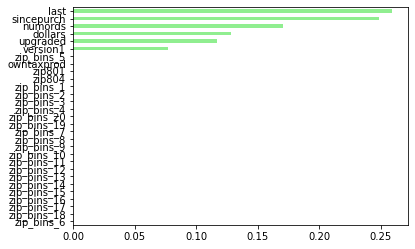

zip_bins_6     0.000000
zip_bins_18    0.000000
zip_bins_17    0.000000
zip_bins_16    0.000000
zip_bins_15    0.000000
zip_bins_14    0.000000
zip_bins_13    0.000000
zip_bins_12    0.000000
zip_bins_11    0.000000
zip_bins_10    0.000000
zip_bins_9     0.000000
zip_bins_8     0.000000
zip_bins_7     0.000000
zip_bins_19    0.000000
zip_bins_20    0.000000
zip_bins_4     0.000000
zip_bins_3     0.000000
zip_bins_2     0.000000
zip_bins_1     0.000000
zip804         0.000000
zip801         0.000000
owntaxprod     0.000000
zip_bins_5     0.000000
version1       0.077323
upgraded       0.116744
dollars        0.128087
numords        0.170145
sincepurch     0.248797
last           0.258904
dtype: float64

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

importances_rf = pd.Series(rf.feature_importances_, index = intuit75k_cols)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='lightgreen'); plt.show()
sorted_importances_rf

In [25]:
roc_rf, profit_rf, cm_rf = performance_profit(X_test, y_test, rf, 'rf', breakeven)
cm_rf

ROC AUC is 0.6770441046789086
Profit is 6504.84


predicted_res_rf,0,1,Total
res_y,,,
0,8413,13007,21420
1,211,869,1080
Total,8624,13876,22500


### Grid Search RF

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 0.12,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [35]:
params_rf = {'criterion': ['gini', 'entropy'],
     'bootstrap': [True, False],
     'max_depth': [10, 20, 30, 40],
     'max_features': ['sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 400, 600, 800],
            'class_weight': ['balanced', 'balanced_subsample']}

In [36]:
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [ ]:
%%time
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [52]:
randomized_rf = RandomizedSearchCV(estimator=rf,
                       param_distributions=params_rf,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5
                      )
#     scoring="roc_auc",verbose=1, estimator=clf, param_distributions=gbm_param_grid, n_jobs=6)
randomized_rf.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [16082.478       nan       nan 15957.48  15811.716 15781.47        nan
       nan 15905.376 15447.   ]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_features=3,
                                                    min_samples_leaf=0.12,
                                                    n_estimators=400,
                                                    oob_score=True,
                                                    random_state=123),
                   n_jobs=8,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
  

In [53]:
best_hyperparams = randomized_rf.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


In [54]:
best_model_rf = randomized_rf.best_estimator_

In [ ]:
roc_rfbest, profit_rfbest, cm_rfbest = performance_profit(X_test, y_test, best_model_rf , 'rfbest', breakeven)
cm_rfbest

<br>

### ADABoost Classifier

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
SEED = 1234

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=100)
adb_clf.fit(X_train, y_train)

y_pred_proba = adb_clf.predict_proba(X_test)[:,1]

adb_clf_roc_auc_score = roc_auc_score(y_test, y_pred_proba)

print('ROC AUC score: {:.2f}'.format(adb_clf_roc_auc_score))

ROC AUC score: 0.69


In [36]:
roc_adb, profit_adb, cm_adb= performance_profit(X_test, y_test, adb_clf, 'adb', breakeven)
cm_adb

ROC AUC is 0.6933122384756372
Profit is 675.0


predicted_res_adb,1,Total
res_y,,
0,21420,21420
1,1080,1080
Total,22500,22500


In [37]:
from sklearn.model_selection import GridSearchCV
adb_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 4,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 0.14,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 168,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.14, random_state=168),
 'learning_rate': 1.0,
 'n_estimators': 100,
 'random_state': None}

In [27]:
 params_adb = {
 'n_estimators': [50, 100, 200, 300],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential'],
 'base_estimator__criterion' : ['gini', 'entropy'],
 'base_estimator__splitter' :   ['best', 'random'],   
 'base_estimator__max_depth' : [None, 1, 3, 5, 10],
 'base_estimator__min_samples_split' : [5,10],
 'base_estimator__min_samples_leaf' : [1, 5 ,10]
 }

In [100]:
grid_adb = GridSearchCV(estimator=adb_clf,
                       param_grid=params_adb,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [ ]:
grid_adb.fit(X_train, y_train)

In [ ]:
best_hyperparams = grid_adb.best_params_
print('Best hyerparameters:\n', best_hyperparams)

In [ ]:
best_model = grid_adb.best_estimator_

In [ ]:
roc_adb_best, profit_adb_best, cm_adb_best = performance_profit(X_test, y_test, best_model , 'adbbest', breakeven)
cm_adb_best

### Stochastic Gradient Boosting (SGB)

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                                   stratify=y,  random_state=SEED, test_size = 0.3)

sgbt = GradientBoostingClassifier(max_depth=1,
                                 subsample = 0.8,
                                 max_features = 0.2,
                                 n_estimators = 300,
                                 random_state = SEED)

sgbt.fit(X_train, y_train)
y_pred = sgbt.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 0.21


In [39]:
roc_sgbt, profit_sgbt, cm_sgbt= performance_profit(X_test, y_test, sgbt, 'sgbt', breakeven)
cm_sgbt

ROC AUC is 0.7614277068852233
Profit is 12153.9


predicted_res_sgbt,0,1,Total
res_y,,,
0,15907,5513,21420
1,383,697,1080
Total,16290,6210,22500


In [40]:
from sklearn.model_selection import GridSearchCV
sgbt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 1,
 'max_features': 0.2,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': 1234,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [41]:
params_sgbt = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [27]:
grid_sgbt = GridSearchCV(estimator=sgbt,
                       param_grid=params_sgbt,
                       scoring=profit_score,
                       cv=5,
                       n_jobs=8,
                      verbose = 5,
                      refit = 'AUC')

In [28]:
grid_sgbt.fit(X_train, y_train)

Fitting 5 folds for each of 84672 candidates, totalling 423360 fits


KeyboardInterrupt: 

In [ ]:
best_hyperparams = grid_sgbt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

In [ ]:
best_model = grid_sgbt.best_estimator_

In [ ]:
roc_sgbt_best, profit_sgbt_best, cm_sgbt_best = performance_profit(X_test, y_test, best_model , 'sgbtbest', breakeven)
cm_sgbt_best

In [ ]:
# clf = xgb.XGBClassifier(objective='binary:logistic',seed=123)
# gbm_param_grid = {
#     'xgb_clf__learning_rate': np.arange(0.05, 0.4, 0.05),
#     'xgb_clf__max_depth': np.arange(1, 6, 1),
#     'xgb_clf__n_estimators': np.arange(1000, 2000, 100)
# }
# randomized_roc_auc = RandomizedSearchCV(scoring="roc_auc",verbose=1, estimator=clf, param_distributions=gbm_param_grid, n_jobs=6)
# randomized_roc_auc.fit(X_train,y_train.values.ravel())


<br>